# Imports

In [1]:
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score,f1_score, ConfusionMatrixDisplay,plot_confusion_matrix,classification_report
import os
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from timeit import default_timer as timer
plt.ion()  

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Dowenload the DataSets

In [2]:
# !pip install  gdown

In [3]:
# !gdown --id 1cOYd5Up8bREeL3RAIble4E7OnOl1afo1
# !gdown --id 1FzY6X-VYziSdwLSavqSfsqCbUW58l0Zq
# !gdown --id 1xFG1_MKcQcRhi5FddHaqz-vejzJm6OzQ

In [4]:
# !unzip "train.zip" 
# !unzip "vali.zip"
# !unzip "test.zip" 
# # !unrar x Dataset.rar

# Ploting Functions

In [5]:
def Show_imgs(DataLoader, Clasessame):
    dataiter = iter(DataLoader)
    images, labels = next(dataiter)
    # images, labels =next(dataiter)
    images = images.numpy() # convert images to numpy for display

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(10):
        ax = fig.add_subplot(2, 10//2, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(Clasessame[labels[idx]])
    images.shape

In [6]:
def plot_confusion_Matrix(y_pred, y_true, plottitle):

    #Create confusion matrix and normalizes it over predicted (columns)
    result = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(result, index = Clasessame, columns= Clasessame) 
    plt.figure(figsize = (10,10))
    plt.title(plottitle)
    sns.heatmap(df_cm, annot=True)
    plt.show()

# Read Images

In [7]:
# data_dir = '/content/'
data_dir=''

train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'vali/')
test_dir = os.path.join(data_dir, 'test/')

trans= transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor()
])

In [8]:
# Change image to tensor
train_data = datasets.ImageFolder(train_dir, transform=trans)
test_data = datasets.ImageFolder(test_dir, transform=trans)
val_data = datasets.ImageFolder(test_dir, transform=trans)

# Classes names'
Clasessame=train_data.classes

# print out some data stats
print('# training images: ', len(train_data))
print('# test images: ', len(test_data))
print('# val images: ', len(val_data))

# training images:  400
# test images:  50
# val images:  50


In [9]:
# define dataloader parameters
batch_size = 10

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

## Visuzlise the images

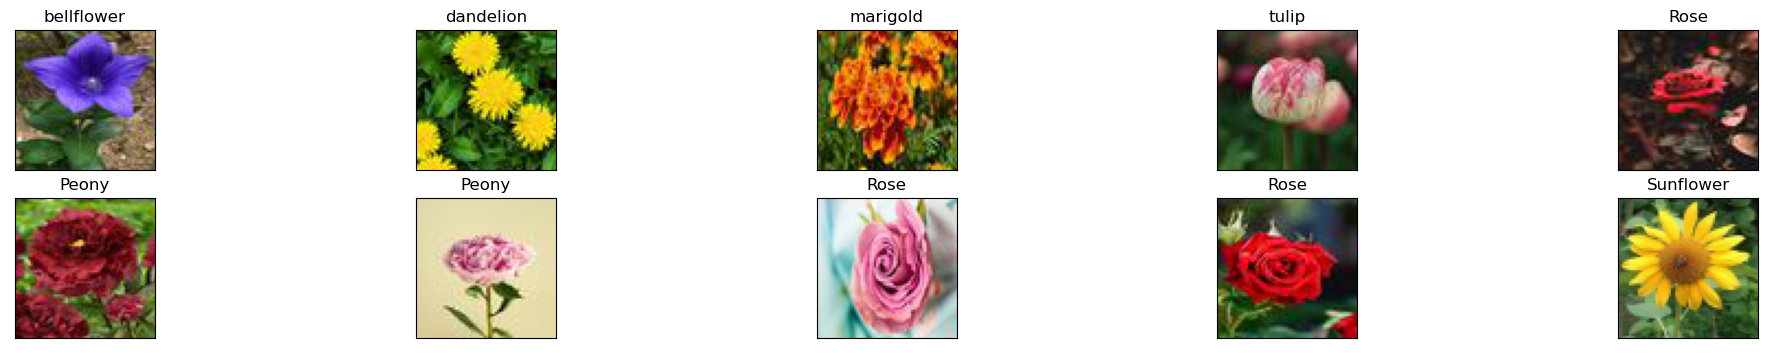

In [10]:
Show_imgs(train_loader, Clasessame)

# Data Augmentation

In [67]:
Aug_tran= transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
   
    transforms.RandomHorizontalFlip(0.4),
    transforms.RandomVerticalFlip(0.4),
    transforms.RandomInvert(0.1),
    transforms.RandomEqualize(0.1),
    transforms.RandomSolarize(0.1),

    transforms.ToTensor()
    

])


In [68]:
# Change image to tensor
Aug_train_data = datasets.ImageFolder(train_dir, transform=Aug_tran)
Aug_train_loader = torch.utils.data.DataLoader(Aug_train_data, batch_size=batch_size, shuffle=True)



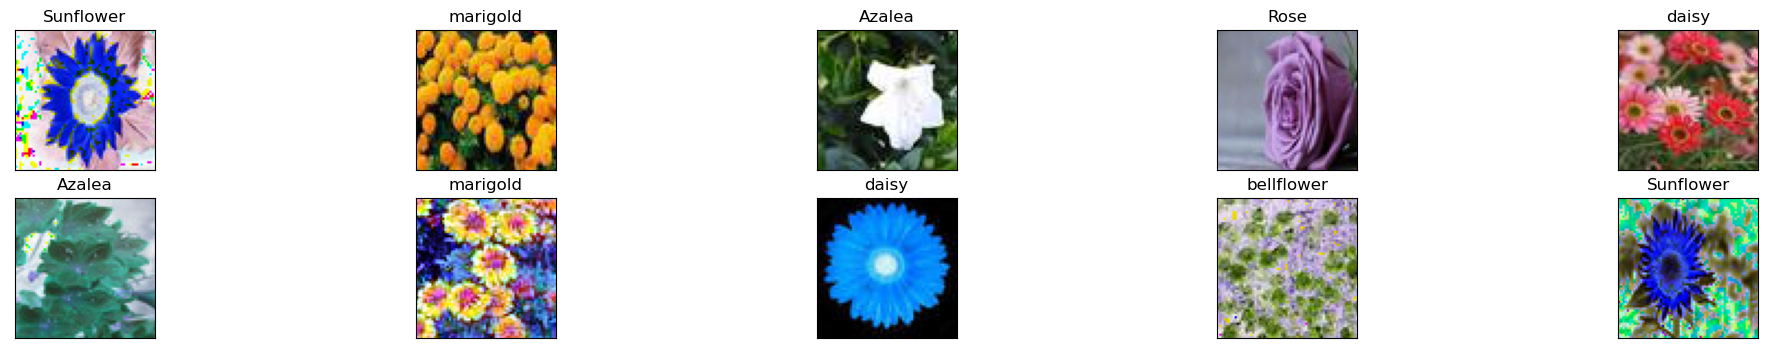

In [59]:
Show_imgs(Aug_train_loader, Clasessame)

# Modeling

## Train Function

In [14]:
def traingig(model ,train_loader, val_loader, criterion, optimizer, max_epochs_stop=5, save_file_name="Model"):
    # number of epochs to train the model
    n_epochs =50
    train__loss=[]
    val_loss=[]
    val_Accuracy = []
    train_Accuracy = []
    
    
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    valid_acc_max = 0
    best_epoch = 0
    valid_max_acc = 0
    
    for epoch in range(1, n_epochs+1):
        start = timer()
        # keep track of training and validation loss
        train_loss = 0.0
        valid_acc = 0.0
        train_acc = 0.0
        valid_losss=0.0
        test_loss = 0.0
        
        # model by default is set to train
        for batch_i, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            # update training loss 
            train_loss += loss.item() * data.size(0)


             # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))

            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (batch_i + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')




        model.eval() # eval mode

        # iterate over test data
        for data, target in val_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update  test loss 
            test_loss += loss.item()*data.size(0)
            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)    
            # compare predictions to true label
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))

            valid_acc += accuracy.item() * data.size(0)
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            # calculate test accuracy for each object class



        valid_acc = valid_acc / len(val_loader.dataset)
        train_acc = train_acc / len(train_loader.dataset)     
        
        valid_losss = test_loss/len(val_loader.dataset)
        train_losss = train_loss/len(train_loader.dataset)

        print(f'\nEpoch: {epoch} \tTraining Loss: {train_losss:.4f} \tValidation Loss: {valid_losss:.4f}')
        print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

        val_Accuracy.append(valid_acc)
        train_Accuracy.append(train_acc)

        # calculate avg test loss
        val_loss.append(valid_losss)
        train__loss.append(train_losss)
        
        
        #Early Stopping
        
        # Save the model if validation loss decreases
        if valid_losss < valid_loss_min:
            # if valid_acc > valid_acc_max:
            # Save model
            torch.save(model.state_dict(), save_file_name)
            # Track improvement
            epochs_no_improve = 0
            valid_loss_min = valid_losss
            valid_acc_max= valid_acc
            # valid_best_acc = valid_acc
            best_epoch = epoch
        

        else:
            epochs_no_improve += 1
            # Trigger early stopping
            if epochs_no_improve >= max_epochs_stop:
                print(
                    f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc_max:.2f}%'
                )
             
                # Load the best state dict
                model.load_state_dict(torch.load(save_file_name))
                # Attach the optimizer
                model.optimizer = optimizer
                return model, train__loss, val_loss, train_Accuracy, val_Accuracy

                    
    return model, train__loss, val_loss, train_Accuracy, val_Accuracy


## Evalution 

In [15]:
# track test loss 
# over 5 flower classes
def eva(model,train_on_gpu,test_loader,criterion):
    
  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  preidcted = np.array([])
  ALL_Labels= np.array([])

  model.eval() # eval mode
  predict=[]
  # iterate over test data
  for data, target in test_loader:
      # move tensors to GPU if CUDA is available
      if train_on_gpu:
          data, target = data.cuda(), target.cuda()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # update  test loss 
      test_loss += loss.item()*data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)    
      # compare predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
      # calculate test accuracy for each object class

      preidcted =np.append(preidcted ,pred.to("cpu").numpy())
      ALL_Labels =np.append(ALL_Labels ,target.to("cpu").numpy())


      for i in range(batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
      predict.append(pred.cpu().numpy())

  # calculate avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))
  # predict=np.array(predict).reshape(-1)
  plot_confusion_Matrix(ALL_Labels, preidcted, 'test')
  print(classification_report(ALL_Labels, preidcted, target_names=Clasessame))
  for i in range(10):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              Clasessame[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (Clasessame[i]))
  
  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))
  
  return class_correct,class_total

In [16]:
def PLot_Carve(trian, vali, PLottitle, YLabel):
    
    plt.figure(figsize=(10,5))
    plt.title(PLottitle)
    
    plt.plot(trian,label="Train")
    plt.plot(vali,label="val")
    
    plt.xlabel("Epochs")
    plt.ylabel(YLabel)
    plt.legend()
    plt.show()      


## VGG16

In [17]:
def Load_VGG_model():
    # Load the pretrained model from pytorch
    VGG16 = models.vgg16(pretrained=True)

    # print out the model structure
    # print(VGG16)

    # Freeze training for all "features" layers
    for param in VGG16.features.parameters():
        param.requires_grad = False
        
    n_inputs = VGG16.classifier[6].in_features
    last_layer = nn.Linear(n_inputs, len(Clasessame), nn.LogSoftmax(dim=1))

    VGG16.classifier[6] = last_layer

    return VGG16

### Befor Data Augmentation

In [18]:
VGG16_Befor_Aug = Load_VGG_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGG16_Befor_Aug.parameters(), lr=0.001, momentum=0.9)

In [19]:
VGG16_Befor_Aug, train_loss, val_loss, train_acc, valid_acc = traingig(
    VGG16_Befor_Aug.to(device),
    train_loader,
    val_loader,
    criterion,
    optimizer,
    save_file_name ="VGG16_Befor_Aug.pt",
    max_epochs_stop = 12)

Epoch: 1	100.00% complete. 2.27 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.7777 	Validation Loss: 1.2294
		Training Accuracy: 39.25%	 Validation Accuracy: 52.00%
Epoch: 2	100.00% complete. 1.60 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.7801 	Validation Loss: 1.0612
		Training Accuracy: 76.50%	 Validation Accuracy: 62.00%
Epoch: 3	100.00% complete. 1.61 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.3612 	Validation Loss: 0.9950
		Training Accuracy: 90.00%	 Validation Accuracy: 70.00%
Epoch: 4	100.00% complete. 1.60 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.2132 	Validation Loss: 0.9591
		Training Accuracy: 96.00%	 Validation Accuracy: 68.00%
Epoch: 5	100.00% complete. 1.60 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.1356 	Validation Loss: 0.9338
		Training Accuracy: 97.00%	 Validation Accuracy: 68.00%
Epoch: 6	100.00% complete. 1.60 seconds elapsed in epoch.
Epoch: 6 	Training Loss: 0.0809 	Validation Loss: 0.9484
		Training Accuracy: 99.7

Test Loss: 0.933771



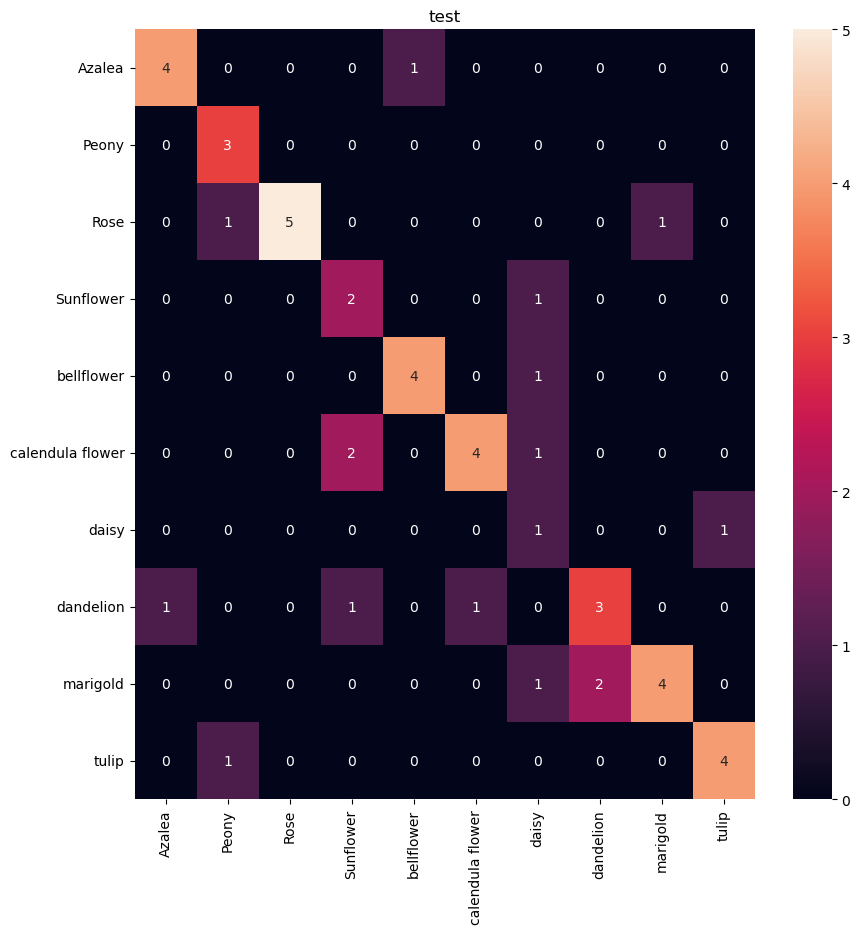

                  precision    recall  f1-score   support

          Azalea       0.80      0.80      0.80         5
           Peony       1.00      0.60      0.75         5
            Rose       0.71      1.00      0.83         5
       Sunflower       0.67      0.40      0.50         5
      bellflower       0.80      0.80      0.80         5
calendula flower       0.57      0.80      0.67         5
           daisy       0.50      0.20      0.29         5
       dandelion       0.50      0.60      0.55         5
        marigold       0.57      0.80      0.67         5
           tulip       0.80      0.80      0.80         5

        accuracy                           0.68        50
       macro avg       0.69      0.68      0.66        50
    weighted avg       0.69      0.68      0.66        50

Test Accuracy of Azalea: 80% ( 4/ 5)
Test Accuracy of Peony: 60% ( 3/ 5)
Test Accuracy of  Rose: 100% ( 5/ 5)
Test Accuracy of Sunflower: 40% ( 2/ 5)
Test Accuracy of bellflower: 80% ( 

([4.0, 3.0, 5.0, 2.0, 4.0, 4.0, 1.0, 3.0, 4.0, 4.0],
 [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0])

In [20]:
eva(VGG16_Befor_Aug,
    train_on_gpu,
    test_loader,
    criterion)

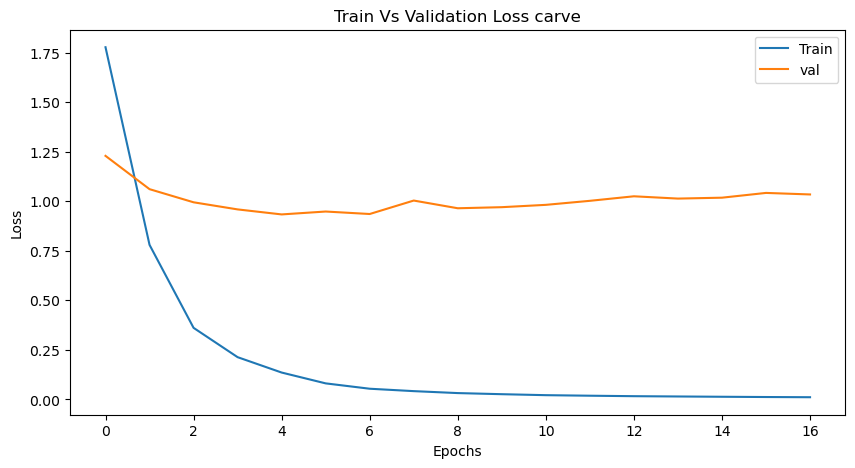

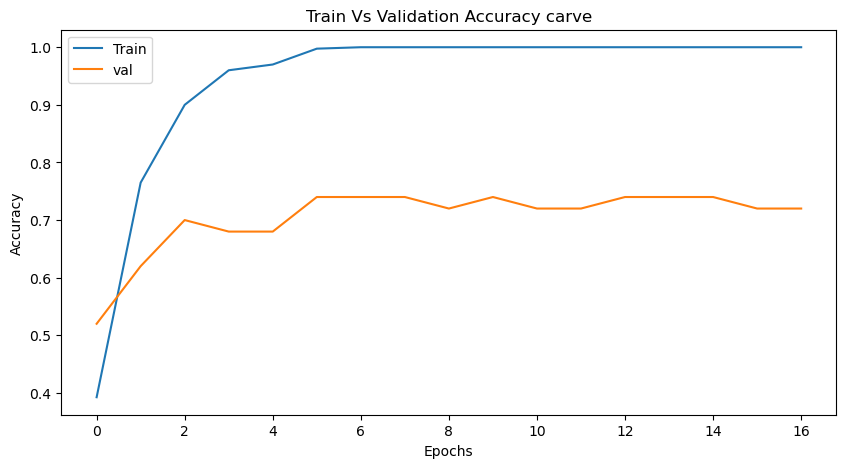

In [21]:
PLot_Carve(train_loss, val_loss, "Train Vs Validation Loss carve", "Loss")
PLot_Carve(train_acc, valid_acc, "Train Vs Validation Accuracy carve", "Accuracy")  

### After Data Augmentation

In [69]:
VGG16_After_Aug = Load_VGG_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGG16_After_Aug.parameters(), lr=0.001, momentum=0.9)

In [70]:
VGG16_After_Aug, train_loss, val_loss, train_acc, valid_acc = traingig(VGG16_After_Aug.to(device),
                                                                       Aug_train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       save_file_name ="VGG16_Befor_Aug.pt",
                                                                       max_epochs_stop = 16)

Epoch: 1	100.00% complete. 1.64 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 2.0357 	Validation Loss: 1.4911
		Training Accuracy: 30.00%	 Validation Accuracy: 46.00%
Epoch: 2	100.00% complete. 1.65 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.3300 	Validation Loss: 1.1007
		Training Accuracy: 56.00%	 Validation Accuracy: 60.00%
Epoch: 3	100.00% complete. 1.65 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.9833 	Validation Loss: 0.9498
		Training Accuracy: 67.50%	 Validation Accuracy: 68.00%
Epoch: 4	100.00% complete. 1.67 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.9354 	Validation Loss: 0.9181
		Training Accuracy: 71.00%	 Validation Accuracy: 70.00%
Epoch: 5	100.00% complete. 1.66 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.8079 	Validation Loss: 0.9516
		Training Accuracy: 72.00%	 Validation Accuracy: 70.00%
Epoch: 6	100.00% complete. 1.65 seconds elapsed in epoch.
Epoch: 6 	Training Loss: 0.6366 	Validation Loss: 1.0100
		Training Accuracy: 78.2

Test Loss: 0.723865



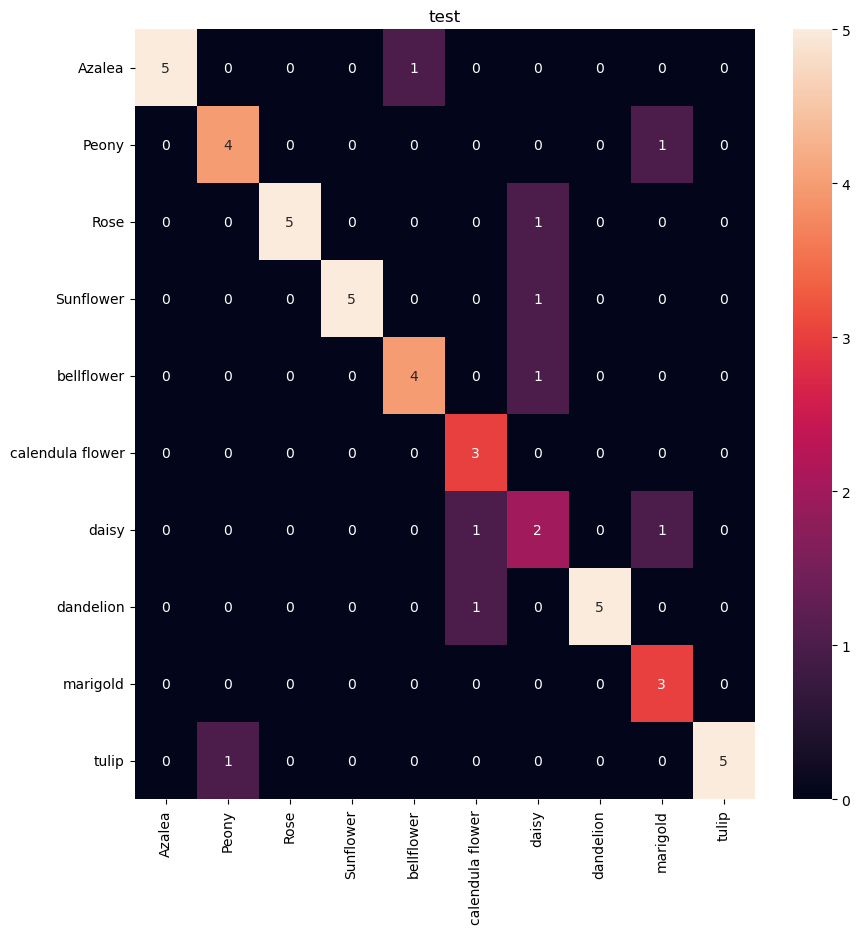

                  precision    recall  f1-score   support

          Azalea       0.83      1.00      0.91         5
           Peony       0.80      0.80      0.80         5
            Rose       0.83      1.00      0.91         5
       Sunflower       0.83      1.00      0.91         5
      bellflower       0.80      0.80      0.80         5
calendula flower       1.00      0.60      0.75         5
           daisy       0.50      0.40      0.44         5
       dandelion       0.83      1.00      0.91         5
        marigold       1.00      0.60      0.75         5
           tulip       0.83      1.00      0.91         5

        accuracy                           0.82        50
       macro avg       0.83      0.82      0.81        50
    weighted avg       0.83      0.82      0.81        50

Test Accuracy of Azalea: 100% ( 5/ 5)
Test Accuracy of Peony: 80% ( 4/ 5)
Test Accuracy of  Rose: 100% ( 5/ 5)
Test Accuracy of Sunflower: 100% ( 5/ 5)
Test Accuracy of bellflower: 80% 

([5.0, 4.0, 5.0, 5.0, 4.0, 3.0, 2.0, 5.0, 3.0, 5.0],
 [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0])

In [71]:
eva(VGG16_After_Aug,train_on_gpu,test_loader,criterion)

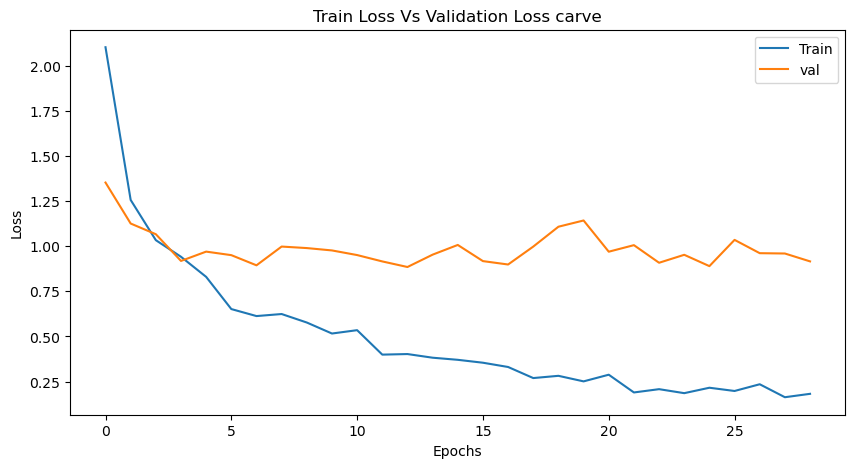

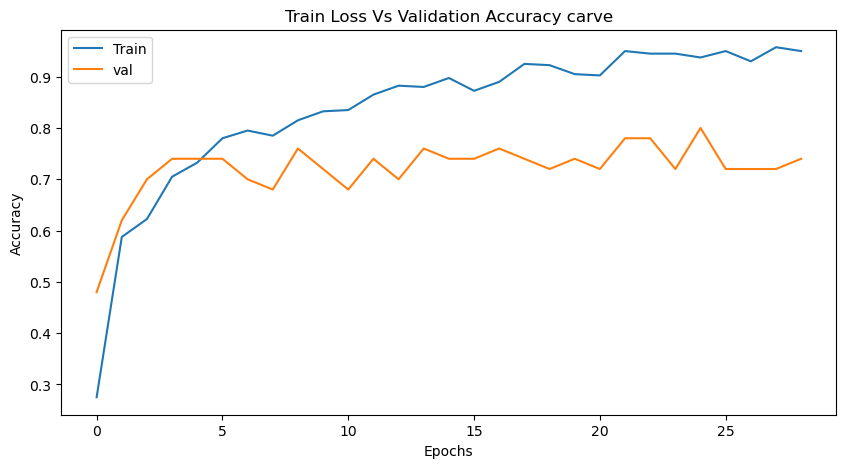

In [25]:
PLot_Carve(train_loss, val_loss, "Train Loss Vs Validation Loss carve", "Loss")
PLot_Carve(train_acc, valid_acc, "Train Loss Vs Validation Accuracy carve", "Accuracy")  

## DenseNet

In [26]:
def Load_DenseNet_model():
    # Load the pretrained model from pytorch
    densenet201 = models.densenet201(pretrained=True)


    # print out the model structure
    # print(VGG16)

    # Freeze training for all "features" layers
    for param in densenet201.features.parameters():
        param.requires_grad = False

    

    n_inputs = densenet201.classifier.in_features
    last_layer = nn.Linear(n_inputs, len(Clasessame), nn.LogSoftmax(dim=1))

    densenet201.classifier = last_layer


    return densenet201

### Befor Data Augmentation

In [27]:
DenseNet_Befor_Aug = Load_DenseNet_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(DenseNet_Befor_Aug.parameters(), lr=0.001, momentum=0.9)

In [28]:
DenseNet_Befor_Aug, train_loss, val_loss, train_acc, valid_acc = traingig(
    DenseNet_Befor_Aug.to(device),
    train_loader,
    val_loader,
    criterion,
    optimizer,
    save_file_name ="DenseNet_Befor_Aug.pt",
    max_epochs_stop = 12)

Epoch: 1	100.00% complete. 1.68 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 2.1271 	Validation Loss: 1.6988
		Training Accuracy: 24.50%	 Validation Accuracy: 50.00%
Epoch: 2	100.00% complete. 1.43 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.1828 	Validation Loss: 1.3148
		Training Accuracy: 66.25%	 Validation Accuracy: 60.00%
Epoch: 3	100.00% complete. 1.45 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.5097 	Validation Loss: 1.1826
		Training Accuracy: 93.25%	 Validation Accuracy: 62.00%
Epoch: 4	100.00% complete. 1.40 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.2954 	Validation Loss: 1.1564
		Training Accuracy: 98.75%	 Validation Accuracy: 60.00%
Epoch: 5	100.00% complete. 1.39 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.1972 	Validation Loss: 1.1278
		Training Accuracy: 99.50%	 Validation Accuracy: 66.00%
Epoch: 6	100.00% complete. 1.42 seconds elapsed in epoch.
Epoch: 6 	Training Loss: 0.1481 	Validation Loss: 1.1292
		Training Accuracy: 100.

Test Loss: 1.107731



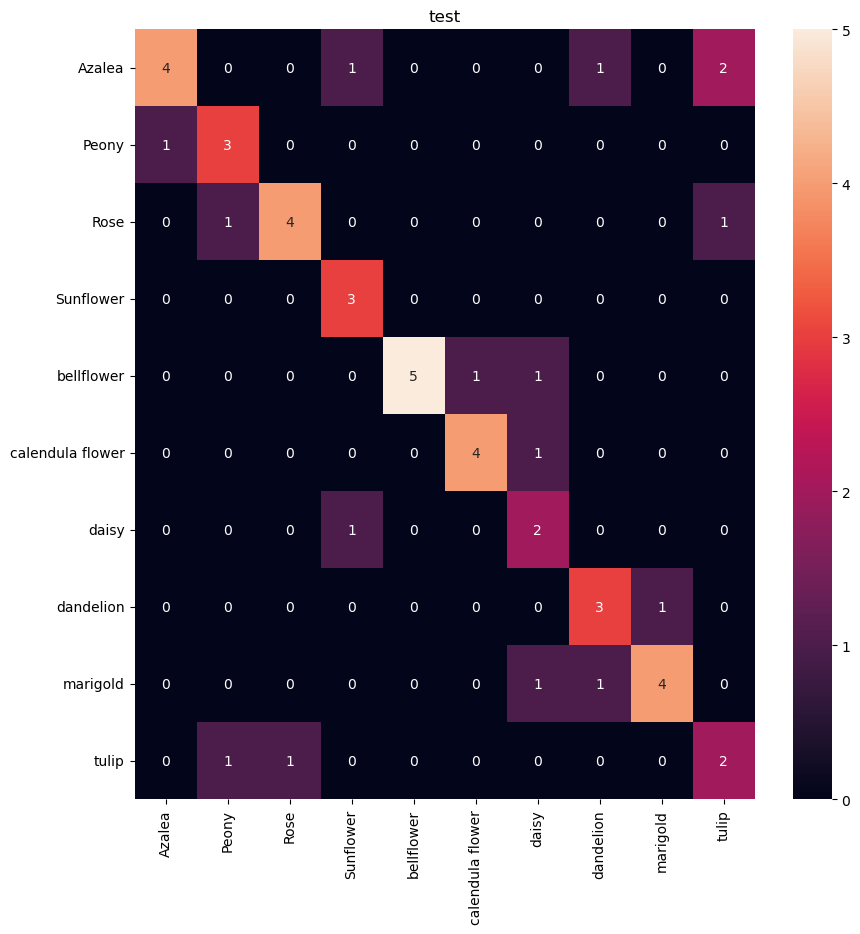

                  precision    recall  f1-score   support

          Azalea       0.50      0.80      0.62         5
           Peony       0.75      0.60      0.67         5
            Rose       0.67      0.80      0.73         5
       Sunflower       1.00      0.60      0.75         5
      bellflower       0.71      1.00      0.83         5
calendula flower       0.80      0.80      0.80         5
           daisy       0.67      0.40      0.50         5
       dandelion       0.75      0.60      0.67         5
        marigold       0.67      0.80      0.73         5
           tulip       0.50      0.40      0.44         5

        accuracy                           0.68        50
       macro avg       0.70      0.68      0.67        50
    weighted avg       0.70      0.68      0.67        50

Test Accuracy of Azalea: 80% ( 4/ 5)
Test Accuracy of Peony: 60% ( 3/ 5)
Test Accuracy of  Rose: 80% ( 4/ 5)
Test Accuracy of Sunflower: 60% ( 3/ 5)
Test Accuracy of bellflower: 100% ( 

([4.0, 3.0, 4.0, 3.0, 5.0, 4.0, 2.0, 3.0, 4.0, 2.0],
 [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0])

In [29]:
eva(DenseNet_Befor_Aug, train_on_gpu, test_loader, criterion)

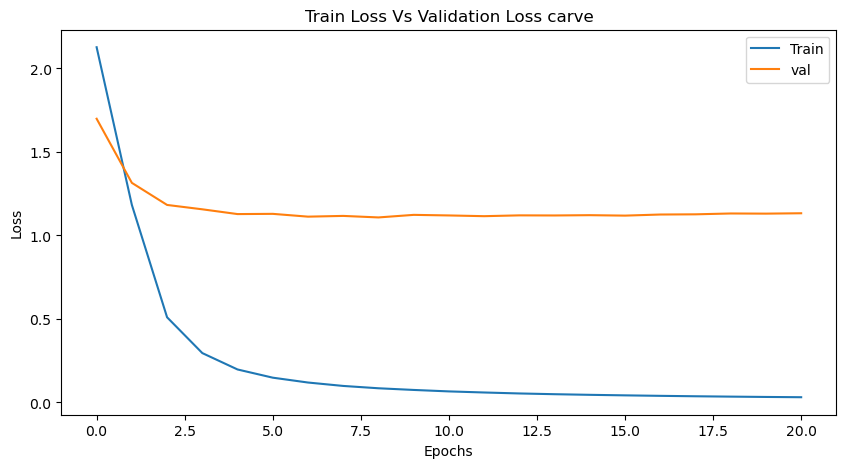

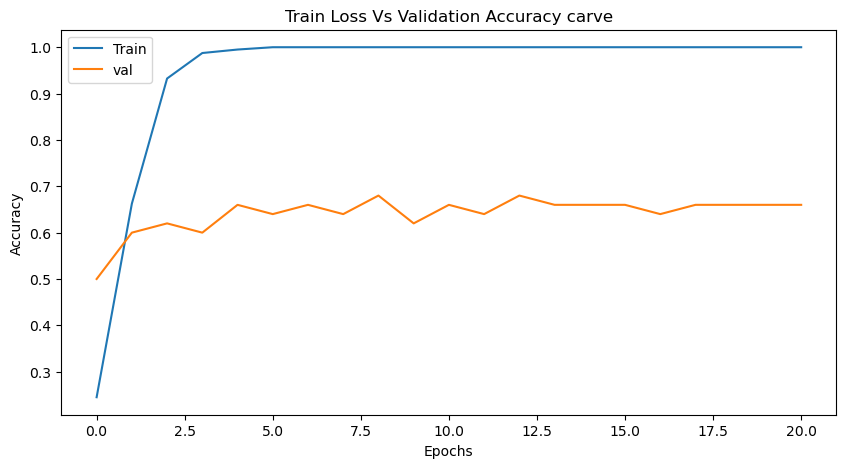

In [30]:
PLot_Carve(train_loss, val_loss, "Train Loss Vs Validation Loss carve", "Loss")
PLot_Carve(train_acc, valid_acc, "Train Loss Vs Validation Accuracy carve", "Accuracy")  

### After Data Augmentation

In [31]:
DenseNet_After_Aug = Load_DenseNet_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(DenseNet_After_Aug.parameters(), lr=0.001, momentum=0.9)

In [32]:
DenseNet_After_Aug, train_loss, val_loss, train_acc, valid_acc = traingig(
    DenseNet_After_Aug.to(device),
    Aug_train_loader,
    val_loader,
    criterion,
    optimizer,
    save_file_name ="DenseNet_After_Aug.pt",
    max_epochs_stop = 12)

Epoch: 1	100.00% complete. 1.73 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 2.2147 	Validation Loss: 1.8087
		Training Accuracy: 18.50%	 Validation Accuracy: 40.00%
Epoch: 2	100.00% complete. 1.49 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.7448 	Validation Loss: 1.3706
		Training Accuracy: 39.75%	 Validation Accuracy: 62.00%
Epoch: 3	100.00% complete. 1.48 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.2979 	Validation Loss: 1.3053
		Training Accuracy: 61.25%	 Validation Accuracy: 52.00%
Epoch: 4	100.00% complete. 1.48 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.9487 	Validation Loss: 1.2292
		Training Accuracy: 71.75%	 Validation Accuracy: 64.00%
Epoch: 5	100.00% complete. 1.46 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.8052 	Validation Loss: 1.1101
		Training Accuracy: 76.75%	 Validation Accuracy: 66.00%
Epoch: 6	100.00% complete. 1.44 seconds elapsed in epoch.
Epoch: 6 	Training Loss: 0.7674 	Validation Loss: 1.0829
		Training Accuracy: 77.0

Test Loss: 0.943443



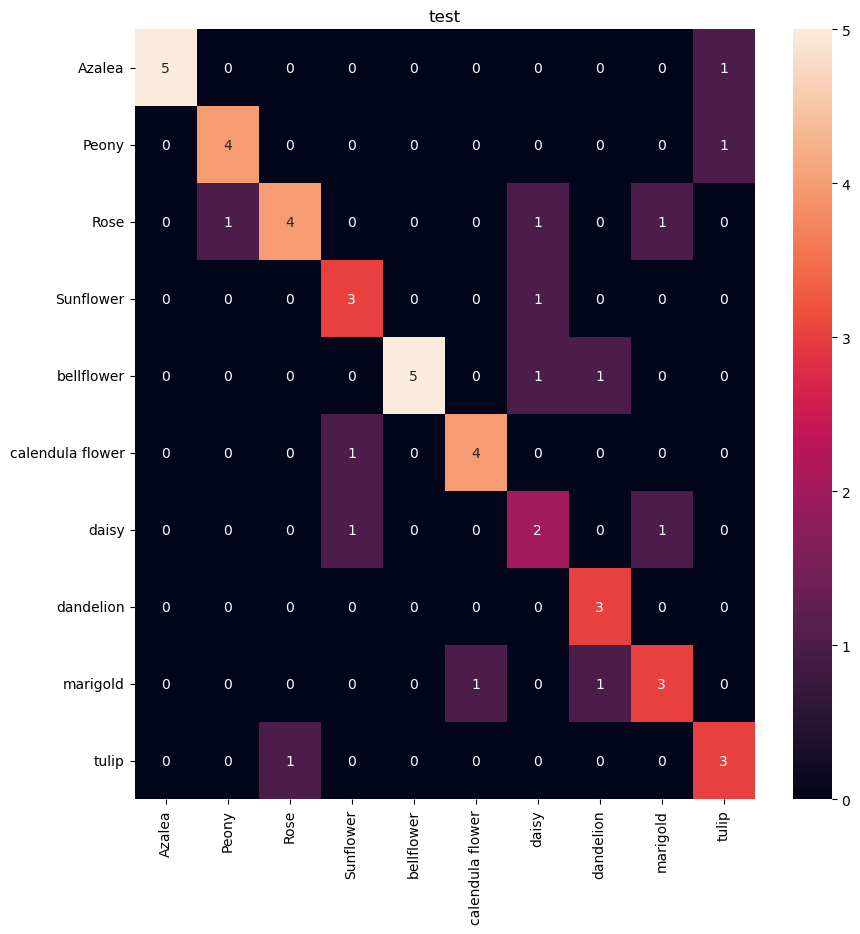

                  precision    recall  f1-score   support

          Azalea       0.83      1.00      0.91         5
           Peony       0.80      0.80      0.80         5
            Rose       0.57      0.80      0.67         5
       Sunflower       0.75      0.60      0.67         5
      bellflower       0.71      1.00      0.83         5
calendula flower       0.80      0.80      0.80         5
           daisy       0.50      0.40      0.44         5
       dandelion       1.00      0.60      0.75         5
        marigold       0.60      0.60      0.60         5
           tulip       0.75      0.60      0.67         5

        accuracy                           0.72        50
       macro avg       0.73      0.72      0.71        50
    weighted avg       0.73      0.72      0.71        50

Test Accuracy of Azalea: 100% ( 5/ 5)
Test Accuracy of Peony: 80% ( 4/ 5)
Test Accuracy of  Rose: 80% ( 4/ 5)
Test Accuracy of Sunflower: 60% ( 3/ 5)
Test Accuracy of bellflower: 100% (

([5.0, 4.0, 4.0, 3.0, 5.0, 4.0, 2.0, 3.0, 3.0, 3.0],
 [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0])

In [33]:
eva(DenseNet_After_Aug, train_on_gpu, test_loader, criterion)

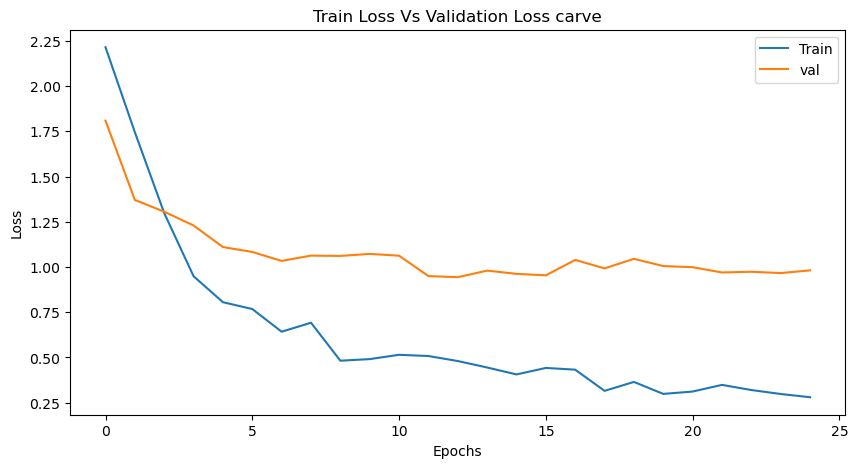

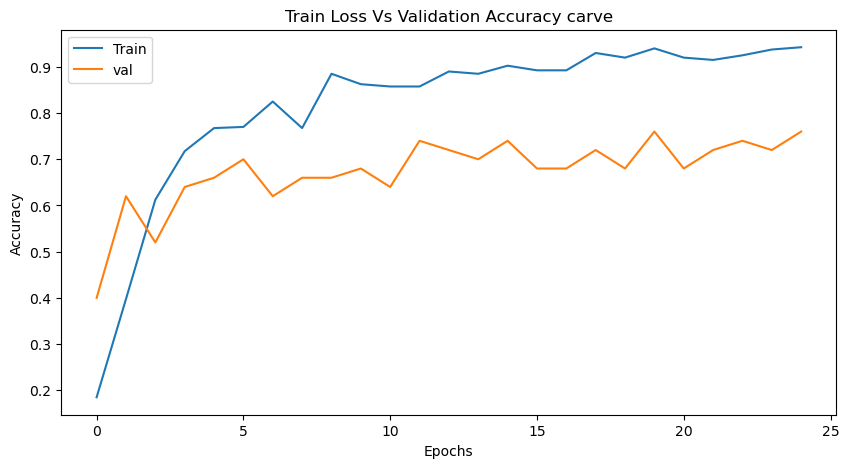

In [34]:
PLot_Carve(train_loss, val_loss, "Train Loss Vs Validation Loss carve", "Loss")
PLot_Carve(train_acc, valid_acc, "Train Loss Vs Validation Accuracy carve", "Accuracy")  